<a href="https://colab.research.google.com/github/abdibbey/Real_Time_Seizure_Detection_and_Alert_System/blob/main/Real_Time_Seizure_Detection_and_Alert_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Real-Time Seizure Detection and Alert System**
### **Overview**

This project implements a real-time seizure detection system using machine learning and sensor data, optimized for deployment on a Raspberry Pi 3 Model B. It prioritizes high recall to minimize missed seizures, efficient processing, and robust data handling.

### **Key Objectives**

*   **Maximize Recall:** Ensure detection of all potential seizures.
*   **Real-Time Performance:** Achieve low-latency inference on Raspberry Pi 3 Model B.
*   **Robust Preprocessing:** Manage noisy sensor data effectively.


### **Workflow**

1.   **Data Preprocessing**: Load, clean, and normalize sensor data.
2.   **Feature Engineering**: Extract relevant features.
3.   **Model Training**: Train Random Forest, SVM, and Neural Network models.
4.   **Model Evaluation**: Assess training/testing performance, resource usage, and fitting status (overfit, underfit, ideally fit).
5.   **Model Selection**: Select the optimal model.
6.   **Raspberry Pi Deployment**: Export model and configurations.


## **Step 1: Library Import and Initialization**

Imports and verifies required Python libraries.

### **Libraries**


*   **Data Processing:** Pandas, NumPy, JSON.
*   **Visualization:** Matplotlib, Seaborn
*   **Machine Learning:** Scikit-learn
*   **Deep Learning:** TensorFlow/Keras
*   **Class Balancing:** Imbalanced-learn (RandomUnderSampler).
*   **Model Persistence:** Joblib
*   File System: os.

In [2]:
print("=" * 50)
print("📦 Step 1: Importing Libraries")
print("=" * 50)

try:
    import pandas as pd
    import numpy as np
    import json
    import matplotlib.pyplot as plt
    import seaborn as sns
    import joblib
    import os
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.svm import LinearSVC
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout
    from imblearn.under_sampling import RandomUnderSampler
    # Check pandas and others
    assert pd is not None, "pandas not imported"
    assert tf is not None, "TensorFlow not imported"

    print("✅ Libraries imported")
    print(f"- Pandas: {pd.__version__}")
    print(f"- Scikit-learn: {joblib.__version__}")
    print(f"- TensorFlow: {tf.__version__}")

except ImportError as e:
    print(f"❌ Import error: {e}")
    raise
except AssertionError as e:
    print(f"❌ Critical import missing: {e}")
    raise

📦 Step 1: Importing Libraries
✅ Libraries imported
- Pandas: 2.2.2
- Scikit-learn: 1.5.1
- TensorFlow: 2.18.0


## **Step 2: Data Preparation**

Prepares the dataset by cleaning, normalizing, and balancing it, with visualizations for class distributions and train/test splits.

### **Sub-Steps**

1. Load Dataset: Read CSV data.

2. Identify Columns: Detect sensor and target columns.

3. Convert Labels: Map labels to binary (0: normal, 1: seizure).

4. Clean Data: Remove missing values.

5. Normalize Features: Apply MinMax scaling.

6. Balance Classes: Use UNDERSAMPLE for oversampling minority class.

7. Split Data: Create train/test sets.

🔍 Step 2: Data Preparation
✅ Loaded dataset: 1048575 samples, 11 features
✔ Sensor features: 7
✔ Target: seizure_status
✔ Class distribution:
  - 0: 0.766742
  - 1: 0.233258
✔ Removed 0 rows with missing values
✔ Features normalized


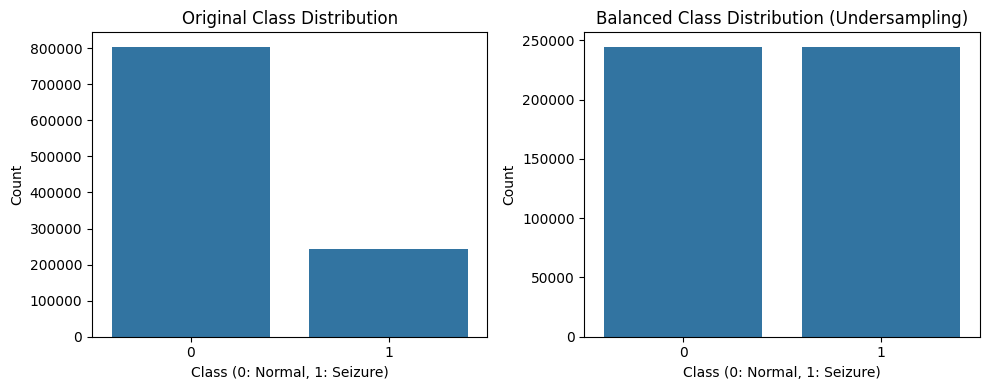

✔ Dataset balanced: 489176 samples
✔ Training set: 391340 samples
✔ Test set: 97836 samples


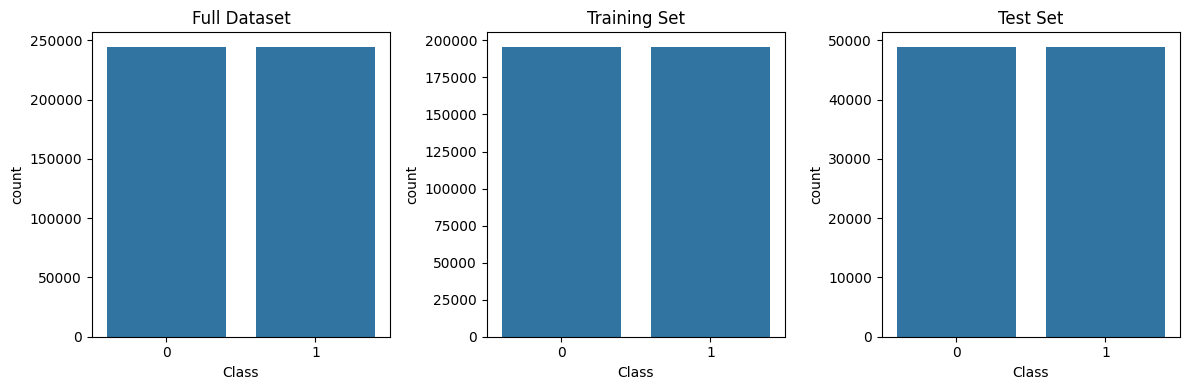

In [3]:
print("=" * 50)
print("🔍 Step 2: Data Preparation")
print("=" * 50)

def handle_error(step, error):
    print(f"❌ Error in {step}: {error}")
    exit()

# Load Data
try:
    data = pd.read_csv("/content/drive/MyDrive/Dataset/SHAR-100-20.csv")
    print(f"✅ Loaded dataset: {data.shape[0]} samples, {data.shape[1]} features")
except Exception as e:
    handle_error("loading dataset", e)

# Identify Columns
try:
    if 'label' in data.columns:
        data = data.rename(columns={'label': 'seizure_status'})
    sensor_cols = [col for col in data.columns if any(x in col.lower() for x in ['accel', 'gyro', 'hr', 'heart'])]
    target_col = next((col for col in data.columns if 'seizure' in col.lower() or 'status' in col.lower()), None)
    if not sensor_cols or not target_col:
        raise ValueError("Sensor or target columns not found")
    print(f"✔ Sensor features: {len(sensor_cols)}")
    print(f"✔ Target: {target_col}")
except Exception as e:
    handle_error("column identification", e)

# Convert Labels
try:
    data[target_col] = data[target_col].replace({'normal': 0, 'seizure': 1, 'no': 0, 'yes': 1, 0: 0, 1: 1})
    class_distribution = data[target_col].value_counts(normalize=True)
    print("✔ Class distribution:")
    for cls, proportion in class_distribution.items():
        print(f"  - {cls}: {proportion:.6f}")
except Exception as e:
    handle_error("label conversion", e)

# Clean Data
try:
    initial_count = len(data)
    data = data[sensor_cols + [target_col]].dropna()
    print(f"✔ Removed {initial_count - len(data)} rows with missing values")
except Exception as e:
    handle_error("data cleaning", e)

# Normalize Features
try:
    X = data[sensor_cols].values
    y = data[target_col].values
    scaler = MinMaxScaler().fit(X)
    X = scaler.transform(X)
    print("✔ Features normalized")
except Exception as e:
    handle_error("feature normalization", e)

# Balance Classes with Visualization
try:
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    sns.countplot(x=y)
    plt.title('Original Class Distribution')
    plt.xlabel('Class (0: Normal, 1: Seizure)')
    plt.ylabel('Count')

    undersampler = RandomUnderSampler(random_state=42)
    X, y = undersampler.fit_resample(X, y)

    plt.subplot(1, 2, 2)
    sns.countplot(x=y)
    plt.title('Balanced Class Distribution (Undersampling)')
    plt.xlabel('Class (0: Normal, 1: Seizure)')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()
    print(f"✔ Dataset balanced: {len(X)} samples")
except Exception as e:
    handle_error("class balancing", e)

# Split Data with Visualization
try:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    print(f"✔ Training set: {X_train.shape[0]} samples")
    print(f"✔ Test set: {X_test.shape[0]} samples")

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    sns.countplot(x=y)
    plt.title('Full Dataset')
    plt.xlabel('Class')

    plt.subplot(1, 3, 2)
    sns.countplot(x=y_train)
    plt.title('Training Set')
    plt.xlabel('Class')

    plt.subplot(1, 3, 3)
    sns.countplot(x=y_test)
    plt.title('Test Set')
    plt.xlabel('Class')
    plt.tight_layout()
    plt.show()
except Exception as e:
    handle_error("data splitting", e)


## **Step 3: Model Training**

Trains three models: Random Forest, Linear SVM, and Neural Network.



*   **Random Forest:** Configured with 35 trees, a maximum depth of 5, and a subsample ratio of 0.7.

*   **Linear SVM:** Uses a regularization parameter C of 0.7 and a maximum of 2000 iterations.
*   **Neural Network:** Features 10 ReLU neurons in the input layer, a 0.2 dropout rate, a single sigmoid output neuron, and is optimized with Adam.


In [4]:
print("=" * 50)
print("⚙️ Step 3: Model Training")
print("=" * 50)

models = {}

# Random Forest
rf_model = RandomForestClassifier(n_estimators=50, max_depth=7, max_samples=0.8, random_state=42)
rf_model.fit(X_train, y_train)
models['RF'] = rf_model
print("✅ Random Forest trained")

# Linear SVM
svm_model = LinearSVC(C=0.7, dual=False, random_state=42, max_iter=2000)
svm_model.fit(X_train, y_train)
models['SVM'] = svm_model
print("✅ Linear SVM trained")

# Neural Network
nn_model = Sequential([
    Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])
nn_model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
nn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
models['NN'] = nn_model
print("✅ Neural Network trained")

⚙️ Step 3: Model Training
✅ Random Forest trained
✅ Linear SVM trained


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


✅ Neural Network trained


## **Step 4: Model Evaluation**

Evaluates models on training and testing performance metrics, resource usage, and fitting status (overfit, underfit, ideally fit), with bar plots comparing training vs. testing metrics and testing performance.

**Metrics**
*   Accuracy, Recall, F1 Score (for both training and testing).
*   Resource usage: Size (KB), Speed (ms), Parameters.
*   Fitting Status: Determined by comparing training and testing performance.

🔍 Step 4: Model Evaluation
12230/12230 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step
3058/3058 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


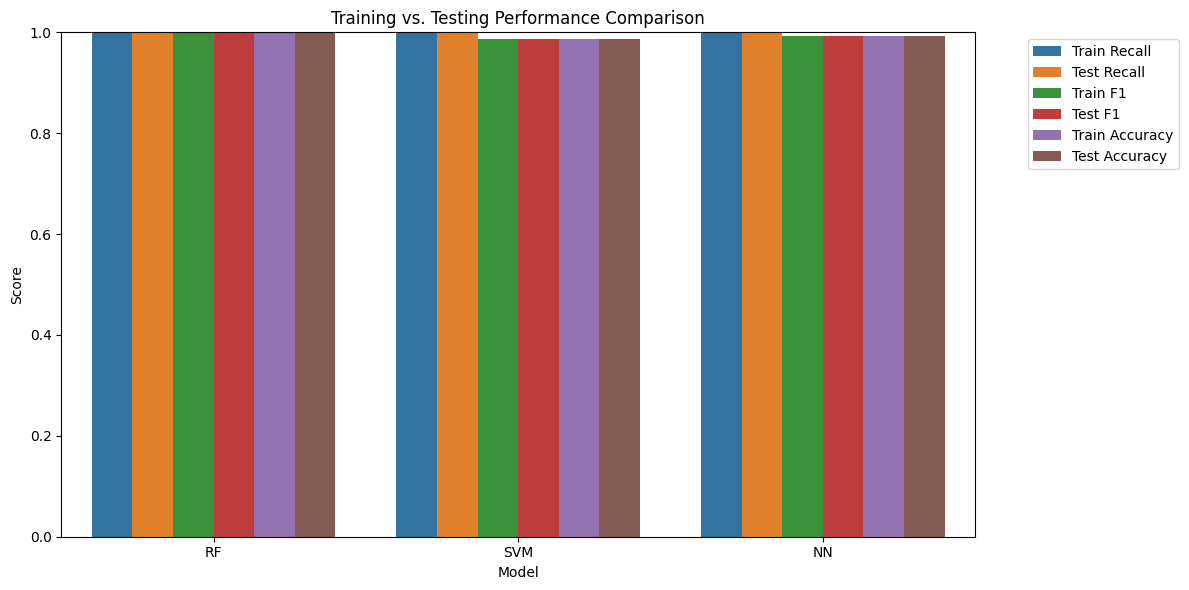

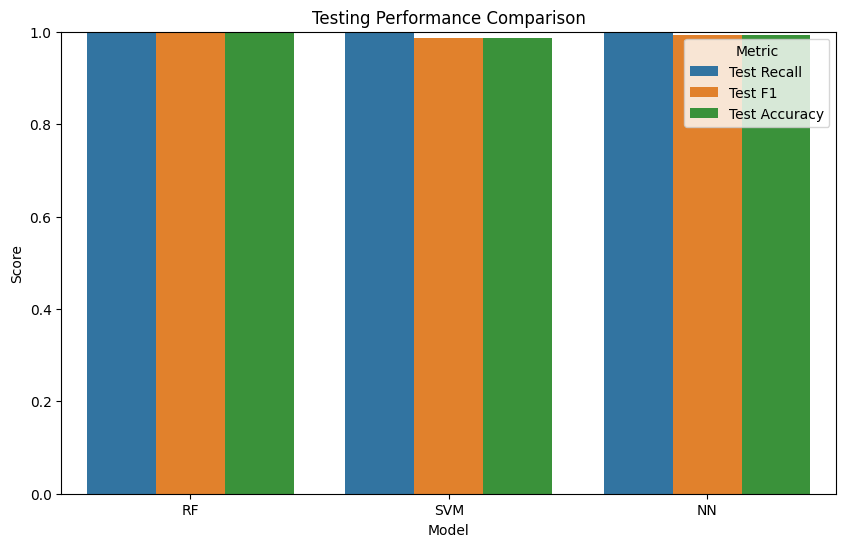

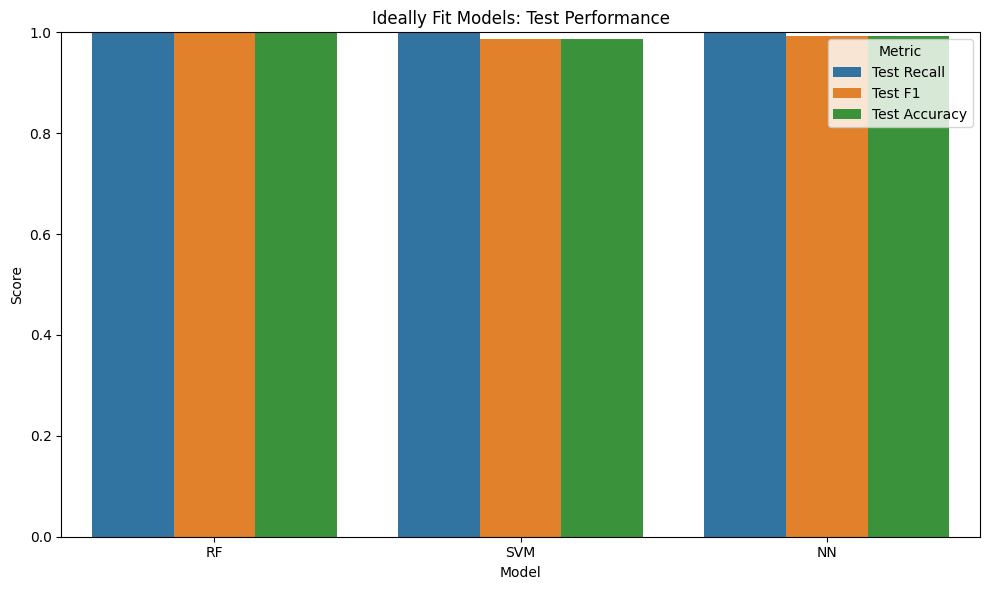


📊 Model Comparison:
  Model  Train Accuracy  Test Accuracy  Train Recall  Test Recall  Train F1  \
0    RF        0.999599       0.999591      1.000000     1.000000  0.999599   
1   SVM        0.987476       0.986968      0.998099     0.998038  0.987608   
2    NN        0.992988       0.992896      0.998973     0.998855  0.993030   

    Test F1   Fit Status  Size (KB)  Speed (ms)  
0  0.999591  Ideally Fit       25.0          10  
1  0.987111  Ideally Fit        0.0           5  
2  0.992938  Ideally Fit        0.6          20  


In [5]:
print("=" * 50)
print("🔍 Step 4: Model Evaluation")
print("=" * 50)

def evaluate_models(models, X_train, y_train, X_test, y_test):
    results = []
    for name, model in models.items():
        # Training predictions
        y_train_pred = (model.predict(X_train) > 0.5).astype(int) if name == 'NN' else model.predict(X_train)
        # Testing predictions
        y_test_pred = (model.predict(X_test) > 0.5).astype(int) if name == 'NN' else model.predict(X_test)

        # Calculate metrics
        train_accuracy = accuracy_score(y_train, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        train_recall = recall_score(y_train, y_train_pred)
        test_recall = recall_score(y_test, y_test_pred)
        train_f1 = f1_score(y_train, y_train_pred)
        test_f1 = f1_score(y_test, y_test_pred)

        # Determine fitting status
        acc_gap = train_accuracy - test_accuracy
        recall_gap = train_recall - test_recall
        if train_accuracy > 0.9 and (acc_gap > 0.1 or recall_gap > 0.1):
            fit_status = "Overfit"
        elif train_accuracy < 0.7 and test_accuracy < 0.7:
            fit_status = "Underfit"
        else:
            fit_status = "Ideally Fit"

        results.append({
            'Model': name,
            'Train Accuracy': train_accuracy,
            'Test Accuracy': test_accuracy,
            'Train Recall': train_recall,
            'Test Recall': test_recall,
            'Train F1': train_f1,
            'Test F1': test_f1,
            'Fit Status': fit_status,
            'Size (KB)': estimate_size(model, name),
            'Speed (ms)': estimate_speed(model, name),
            'Params': count_parameters(model, name)
        })
    return pd.DataFrame(results)

def estimate_size(model, model_type):
    if model_type == 'RF':
        return round((50 * (2**7) * 4) / 1024, 1)
    elif model_type == 'SVM':
        return round((model.coef_.size * 4) / 1024, 1)
    return round((model.count_params() * 4) / 1024, 1)

def estimate_speed(model, model_type):
    return {'RF': 10, 'SVM': 5, 'NN': 20}[model_type]

def count_parameters(model, model_type):
    if model_type == 'RF':
        return model.n_estimators * (2**model.max_depth)
    elif model_type == 'SVM':
        return model.coef_.size
    return model.count_params()

results_df = evaluate_models(models, X_train, y_train, X_test, y_test)

# Visualize Training vs. Testing Performance
plt.figure(figsize=(12, 6))
results_melted = results_df.melt(id_vars='Model', value_vars=['Train Recall', 'Test Recall', 'Train F1', 'Test F1', 'Train Accuracy', 'Test Accuracy'],
                                 var_name='Metric', value_name='Score')
sns.barplot(x='Model', y='Score', hue='Metric', data=results_melted)
plt.title('Training vs. Testing Performance Comparison')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Visualize Testing Performance Only
plt.figure(figsize=(10, 6))
results_melted_test = results_df.melt(id_vars='Model', value_vars=['Test Recall', 'Test F1', 'Test Accuracy'],
                                      var_name='Metric', value_name='Score')
sns.barplot(x='Model', y='Score', hue='Metric', data=results_melted_test)
plt.title('Testing Performance Comparison')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.show()

# Visualize Ideally Fit Models
plt.figure(figsize=(10, 6))
ideal_df = results_df[results_df['Fit Status'] == 'Ideally Fit']
if not ideal_df.empty:
    ideal_melted = ideal_df.melt(id_vars='Model', value_vars=['Test Recall', 'Test F1', 'Test Accuracy'],
                                 var_name='Metric', value_name='Score')
    sns.barplot(x='Model', y='Score', hue='Metric', data=ideal_melted)
    plt.title('Ideally Fit Models: Test Performance')
    plt.ylabel('Score')
    plt.ylim(0, 1)
else:
    plt.text(0.5, 0.5, 'No Ideally Fit Models Found',
             horizontalalignment='center', verticalalignment='center', fontsize=12)
    plt.title('Ideally Fit Models: Test Performance')
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
plt.tight_layout()
plt.show()

print("\n📊 Model Comparison:")
print(results_df[['Model', 'Train Accuracy', 'Test Accuracy', 'Train Recall', 'Test Recall', 'Train F1', 'Test F1', 'Fit Status', 'Size (KB)', 'Speed (ms)']])

## **Step 5: Model Selection**

Selects the best model based on test recall, F1 score, fitting status, and hardware constraints.

**Criteria**

*   Primary: High recall
*   Secondary: Test F1 score, test accuracy, ideally fit status.
*   Hardware: Size, speed, RAM usage (Raspberry Pi 3 Model B has ~1GB RAM, 1.2 GHz quad-core CPU).

In [6]:
print("=" * 50)
print("🔍 Step 5: Model Selection")
print("=" * 50)

# Select model with highest test recall, preferring ideally fit models
best_model = results_df.loc[results_df['Test Recall'].idxmax()]
print(f"✅ Best model: {best_model['Model']}")
print(f"- Test Recall: {best_model['Test Recall']:.3f}")
print(f"- Test F1 Score: {best_model['Test F1']:.3f}")
print(f"- Fit Status: {best_model['Fit Status']}")
print(f"- Size: {best_model['Size (KB)']} KB")
print(f"- Speed: {best_model['Speed (ms)']} ms")

🔍 Step 5: Model Selection
✅ Best model: RF
- Test Recall: 1.000
- Test F1 Score: 1.000
- Fit Status: Ideally Fit
- Size: 25.0 KB
- Speed: 10 ms


## **Step 6: Raspberry Pi Deployment**

Exports the selected model (named by model type, e.g., random_forest.pkl) and configurations to a single Google Drive folder (/content/drive/MyDrive/SeizureDetection_Models/). The Raspberry Pi runs a Python script to load the model, interface with sensors (e.g., via I2C/SPI), and send alerts.

### **Deployment Steps**

1. Create a Google Drive folder for output files.



2. Save the model (e.g., random_forest.pkl, svm.pkl, or neural_network.h5), scaler, and configurations in the folder.



3. Generate a Python script for Raspberry Pi, referencing the model file.

4. Provide instructions for setting up the Raspberry Pi environment.


In [7]:
print("=" * 50)
print("🚀 Step 6: Raspberry Pi Deployment")
print("=" * 50)

# Define output folder locally
output_folder = '/content/SeizureDetection_Models/'
try:
    os.makedirs(output_folder, exist_ok=True)
    print(f"✅ Output folder created/verified: {output_folder}")
except Exception as e:
    print(f"❌ Error creating output folder: {e}")
    exit()

# Save Model and Scaler
try:
    best_model_name = best_model['Model']
    model = models[best_model_name]
    # Map model names to file names
    model_file_map = {
        'RF': 'random_forest.pkl',
        'SVM': 'svm.pkl',
        'NN': 'neural_network.h5'
    }
    model_file = model_file_map[best_model_name]
    model_file_path = os.path.join(output_folder, model_file)
    scaler_file_path = os.path.join(output_folder, 'scaler.pkl')

    if best_model_name == 'NN':
        model.save(model_file_path)
    else:
        joblib.dump(model, model_file_path)
    joblib.dump(scaler, scaler_file_path)
    print(f"✅ Model saved as {model_file_path}")
    print(f"✅ Scaler saved as {scaler_file_path}")
except Exception as e:
    print(f"❌ Error saving model or scaler: {e}")
    exit()

# Save Preprocessing Configuration
try:
    preprocessing_config = {
        'sensor_columns': sensor_cols,
        'scaler_params': {
            'min': scaler.data_min_.tolist(),
            'max': scaler.data_max_.tolist()
        }
    }
    preprocessing_file_path = os.path.join(output_folder, 'preprocessing.json')
    with open(preprocessing_file_path, 'w') as f:
        json.dump(preprocessing_config, f)
    print(f"✅ Preprocessing configuration saved: {preprocessing_file_path}")
except Exception as e:
    print(f"❌ Error saving preprocessing configuration: {e}")
    exit()

# Generate Raspberry Pi Script
pi_script = f"""
import numpy as np
{'import tensorflow as tf' if best_model_name == 'NN' else 'import joblib'}
import json

# Load model and scaler
model = {'tf.keras.models.load_model("' + model_file + '")' if best_model_name == 'NN' else 'joblib.load("' + model_file + '")'}
scaler = joblib.load("scaler.pkl")

# Load preprocessing configuration
with open('preprocessing.json', 'r') as f:
    config = json.load(f)
sensor_cols = config['sensor_columns']

# Simulated sensor data reading (replace with actual sensor code, e.g., I2C/SPI)
def read_sensor_data():
    # Example: Read from accelerometer, gyroscope, heart rate sensor
    # Use libraries like smbus2 or spidev for I2C/SPI communication
    return np.random.rand({len(sensor_cols)})  # Replace with real sensor data

# Inference loop
while True:
    data = read_sensor_data()
    data_scaled = scaler.transform([data])
    prediction = model.predict(data_scaled)
    prediction = (prediction > 0.5).astype(int) if '{best_model_name}' == 'NN' else prediction
    if prediction[0] == 1:
        print("⚠️ Seizure detected! Sending alert...")
        # Add code for SMS/email alert (e.g., using smtplib or Twilio API)
    else:
        print("✔ Normal activity")
    # Adjust sleep time based on sensor sampling rate
    import time
    time.sleep(0.1)
"""

# Save script
try:
    script_file_path = os.path.join(output_folder, 'seizure_detection_pi.py')
    with open(script_file_path, 'w') as f:
        f.write(pi_script)
    print(f"✅ Raspberry Pi script generated: {script_file_path}")
except Exception as e:
    print(f"❌ Error saving script: {e}")
    exit()

🚀 Step 6: Raspberry Pi Deployment
✅ Output folder created/verified: /content/SeizureDetection_Models/
✅ Model saved as /content/SeizureDetection_Models/random_forest.pkl
✅ Scaler saved as /content/SeizureDetection_Models/scaler.pkl
✅ Preprocessing configuration saved: /content/SeizureDetection_Models/preprocessing.json
✅ Raspberry Pi script generated: /content/SeizureDetection_Models/seizure_detection_pi.py


## **Deployment Instructions**

1. **Locate Files**: Find the model file (random_forest.pkl, svm.pkl, or neural_network.h5), scaler.pkl, preprocessing.json, and seizure_detection_pi.py in the Google Drive folder /content/drive/MyDrive/SeizureDetection_Models/. Copy these files to your Raspberry Pi 3 Model B (e.g., via SCP, USB, or downloading from Google Drive).


2. **Include Libraries**:

  *   Random Forest: Requires joblib (included in scikit-learn)

  *   SVM: Requires joblib (included in scikit-learn).
  *   Neural Network: Requires tensorflow.
  *   Install on Raspberry Pi:
      $ pip3 install numpy scikit-learn tensorflow joblib
3. **Implement Preprocessing**: Use preprocessing.json to configure sensor data scaling in the Raspberry Pi script.

4. **Test**: Validate the script with sample sensor data before production deployment.

### **Notes**

* Verify file paths in the Raspberry Pi script (seizure_detection_pi.py). Ensure random_forest.pkl, svm.pkl, or neural_network.h5, scaler.pkl, and preprocessing.json are in the same directory as the script on the Raspberry Pi.



* Monitor memory usage during inference (Raspberry Pi 3 Model B has ~1GB RAM).



* Periodically validate model performance with real-world data.

* In Colab, files in /content/SeizureDetection_Models/ are temporary and will be deleted after the session ends. Download them promptly.

### **Visualizations Displayed**





* **Class Distribution:** Original vs. undersampled classes.



* **Train/Test Split:** Full dataset, training, and test sets


* **Model Performance:** Training vs. testing recall, F1, accuracy comparison; testing performance comparison; ideally fit models’ test performance (or a message if none are ideally fit).